In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, Add, Activation, Dense, LSTM, Dropout, Embedding
from tensorflow.keras.layers import Flatten, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Load the data
data_path = 'SunoCaps_dataset.csv'
data = pd.read_csv(data_path)

# Display the dataset structure
data.head()

,ytid_V,Comments,Emotion,Extra_emotion,aspect_version,caption_version,shorth_aspect,short_caption,Instrumental,aspect_list,caption
0,-0Gj8-vB1q4_1,Not low quality. No strings,Sad,NaN,True,False,False,True,False,"low quality, sustained strings melody, soft fe...",The low quality recording features a ballad so...
1,-0Gj8-vB1q4_2,Not low quality. No strings,Sad,NaN,True,False,False,True,False,"low quality, sustained strings melody, soft fe...",The low quality recording features a ballad so...
2,-0Gj8-vB1q4_3,No strings,Sad,NaN,False,True,False,True,False,"low quality, sustained strings melody, soft fe...",The low quality recording features a ballad so...
3,-0Gj8-vB1q4_4,No strings. Not clearly a female voice,Sad,NaN,False,True,False,True,False,"low quality, sustained strings melody, soft fe...",The low quality recording features a ballad so...
4,-1UWSisR2zo_1,Not poor audio quality. No ambient noises,Exciting,Energetic,True,False,True,True,False,"live performance, poor audio quality, ambient ...",A male singer sings this groovy melody. The so...


In [3]:
# Extract relevant columns and check for null values
data = data[['Comments', 'Emotion', 'caption']].dropna()

# Encode 'Emotion' as labels
label_encoder = LabelEncoder()
data['Emotion_encoded'] = label_encoder.fit_transform(data['Emotion'])

# Convert 'Comments' and 'caption' to embeddings for use as inputs
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize and convert text to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['caption'])
sequences = tokenizer.texts_to_sequences(data['caption'])
max_sequence_length = max([len(seq) for seq in sequences])

# Pad sequences for equal length input
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Prepare data for training
X = padded_sequences
y = data['Emotion_encoded'].values

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Define the WaveNet model architecture
def build_wavenet(input_shape, num_classes, num_filters=64, kernel_size=2, dilation_rates=[1, 2, 4, 8]):
    inputs = Input(shape=input_shape)
    x = inputs

    # Add dilated convolutions
    for dilation_rate in dilation_rates:
        x = Conv1D(num_filters, kernel_size, padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
    
    # Output layer
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs, x)

# Instantiate WaveNet model
wavenet_model = build_wavenet((X_train.shape[1], 1), num_classes=len(label_encoder.classes_))
wavenet_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
wavenet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 40, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 40, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 40, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 40, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        25,610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,570 (197.54 KB)

 Trainable params: 50,570 (197.54 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Define the LSTM model architecture
def build_lstm(input_shape, num_classes, num_units=64):
    model = Sequential([
        Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=input_shape[0]),
        LSTM(num_units, return_sequences=True),
        LSTM(num_units),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Instantiate LSTM model
lstm_model = build_lstm((X_train.shape[1],), num_classes=len(label_encoder.classes_))
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
lstm_model.summary()

C:\Users\my computer\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Print shapes of training and validation data for debugging
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Reshape X_train and X_val for WaveNet if needed (e.g., for 1D convolutions)
X_train_wavenet = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_wavenet = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
]

# Train WaveNet Model
print("Training WaveNet model...")
history_wavenet = wavenet_model.fit(
    X_train_wavenet, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_wavenet, y_val),
    callbacks=callbacks
)

# Train LSTM Model (no reshaping needed if model is expecting (batch_size, sequence_length) format)
print("Training LSTM model...")
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

X_train shape: (146, 40)
y_train shape: (146,)
X_val shape: (37, 40)
y_val shape: (37,)
Training WaveNet model...
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.1603 - loss: 7.2042 - val_accuracy: 0.2973 - val_loss: 4.1049
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5497 - loss: 1.7513 - val_accuracy: 0.4324 - val_loss: 3.7122
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6256 - loss: 1.3196 - val_accuracy: 0.4324 - val_loss: 2.6589
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7551 - loss: 0.8060 - val_accuracy: 0.5946 - val_loss: 2.1543
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8023 - loss: 0.6600 - val_accuracy: 0.6216 - val_loss: 2.0369
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7705 - loss: 0.5790 - val_accuracy: 0.6216 - val_loss: 1.8166
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7988 - loss: 0.5277 - val_accuracy: 0.5946 - val_loss: 1.6907
Epoch 8/10

WaveNet history keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
LSTM history keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


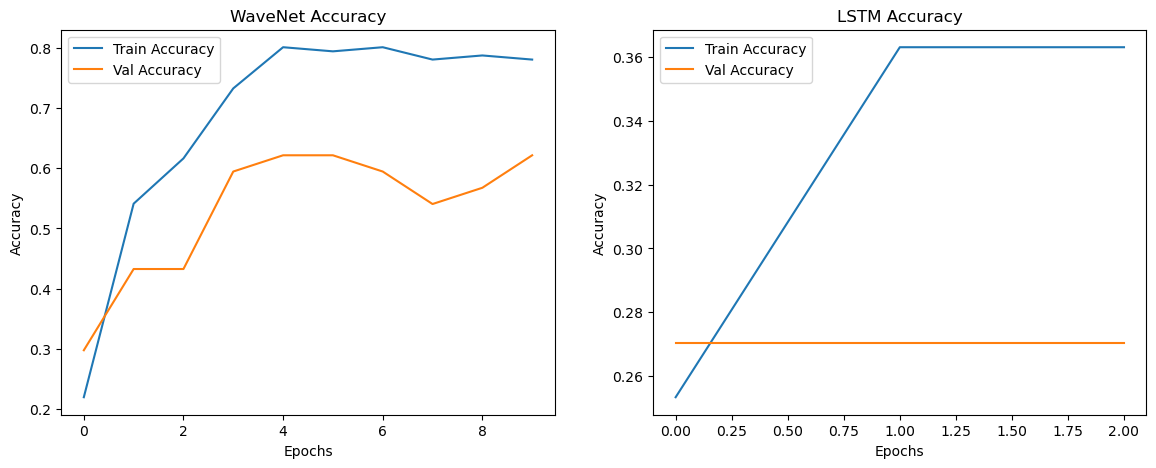

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6123 - loss: 2.0026
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2739 - loss: 1.9437 
WaveNet Validation Loss, Accuracy: [1.9720088243484497, 0.6216216087341309]
LSTM Validation Loss, Accuracy: [1.9397201538085938, 0.2702702581882477]


In [29]:
import matplotlib.pyplot as plt

# Check what metrics are available in history
print("WaveNet history keys:", history_wavenet.history.keys())
print("LSTM history keys:", history_lstm.history.keys())

# Plot training & validation accuracy if available
plt.figure(figsize=(14, 5))

# Check if 'accuracy' exists in history and plot WaveNet accuracy
if 'accuracy' in history_wavenet.history and 'val_accuracy' in history_wavenet.history:
    plt.subplot(1, 2, 1)
    plt.plot(history_wavenet.history['accuracy'], label='Train Accuracy')
    plt.plot(history_wavenet.history['val_accuracy'], label='Val Accuracy')
    plt.title('WaveNet Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
else:
    print("WaveNet accuracy metrics not found in history.")

# Check if 'accuracy' exists in history and plot LSTM accuracy
if 'accuracy' in history_lstm.history and 'val_accuracy' in history_lstm.history:
    plt.subplot(1, 2, 2)
    plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
    plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
    plt.title('LSTM Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
else:
    print("LSTM accuracy metrics not found in history.")

plt.show()

# Evaluate models on validation set and print results
wavenet_eval = wavenet_model.evaluate(X_val_wavenet, y_val)
lstm_eval = lstm_model.evaluate(X_val, y_val)

print("WaveNet Validation Loss, Accuracy:", wavenet_eval)
print("LSTM Validation Loss, Accuracy:", lstm_eval)

In [31]:
# Generate a sample using WaveNet
def generate_wavenet_sample(model, input_seq, num_steps=50):
    generated = []
    input_seq = input_seq.reshape(1, -1, 1)  # Reshape for model input
    for _ in range(num_steps):
        # Predict next token
        prediction = np.argmax(model.predict(input_seq), axis=-1)
        generated.append(prediction[0, -1])
        
        # Roll sequence and add the new token
        input_seq = np.roll(input_seq, -1)
        input_seq[0, -1, 0] = prediction[0, -1]  # Update the last element
    return generated

# Generate a sample using LSTM
def generate_lstm_sample(model, input_seq, num_steps=50):
    generated = []
    input_seq = input_seq.reshape(1, -1)  # Reshape for model input
    for _ in range(num_steps):
        # Predict next token
        prediction = np.argmax(model.predict(input_seq), axis=-1)
        generated.append(prediction[0])
        
        # Roll sequence and add the new token
        input_seq = np.roll(input_seq, -1)
        input_seq[0, -1] = prediction[0]  # Update the last element
    return generated

# Debugging: Print shapes before generating samples
print("X_val shape for sample generation:", X_val.shape)

# Generate samples and display results
sample_input = X_val[0]  # Use a random sequence from validation data

# For WaveNet, reshape sample_input to match model input shape
sample_input_wavenet = sample_input.reshape(1, -1, 1)

# Generate sequences
try:
    wavenet_sample = generate_wavenet_sample(wavenet_model, sample_input_wavenet)
    print("WaveNet Generated Sequence:", wavenet_sample)
except Exception as e:
    print("Error generating WaveNet sample:", e)

try:
    lstm_sample = generate_lstm_sample(lstm_model, sample_input)
    print("LSTM Generated Sequence:", lstm_sample)
except Exception as e:
    print("Error generating LSTM sample:", e)

X_val shape for sample generation: (37, 40)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Error generating WaveNet sample: too many indices for array: array is 1-dimensional, but 2 were indexed
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━